# PNP_DRUNet

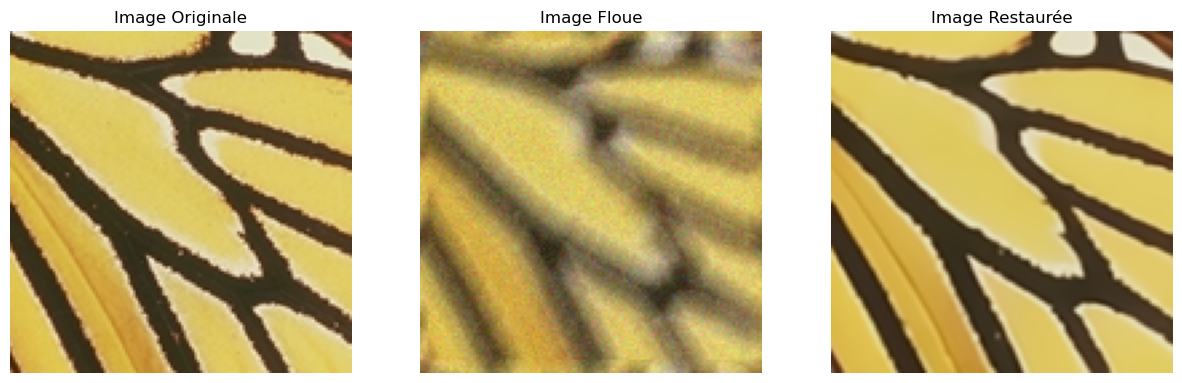

In [13]:
import deepinv as dinv
from PIL import Image
from pathlib import Path
import torch
from torchvision import transforms
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.optim.dpir import get_DPIR_params
from deepinv.utils.demo import load_degradation
import matplotlib.pyplot as plt
import numpy as np

# Chemins de base
BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR/ "datasets"
DEG_DIR = BASE_DIR / "degradations"

# Charger une unique image
image_path = ORIGINAL_DATA_DIR / "butterfly.png"  # Remplacez par le chemin de votre image
image = Image.open(image_path).convert("RGB")

# Transformations
img_size = 128  # Ou la taille que vous souhaitez
val_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
image_tensor = val_transform(image).unsqueeze(0)  # Ajout de la dimension batch

# Configuration du périphérique
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
image_tensor = image_tensor.to(device)

# Génération d'un opérateur de flou
kernel_index = 1  # Choisissez un kernel parmi les disponibles
kernel_torch = load_degradation("Levin09.npy", DEG_DIR / "kernels", index=kernel_index)
kernel_torch = kernel_torch.unsqueeze(0).unsqueeze(0).to(device)  # Ajout de dimensions batch et canal

# Application du flou
noise_level_img = 0.03
n_channels = 3
p = dinv.physics.BlurFFT(
    img_size=(n_channels, img_size, img_size),
    filter=kernel_torch,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)

# Création d'une image floue
blurred_image = p(image_tensor)

# Configuration de l'algorithme DPIR
sigma_denoiser, stepsize, max_iter = get_DPIR_params(noise_level_img)
params_algo = {"stepsize": stepsize, "g_param": sigma_denoiser}
data_fidelity = L2()
prior = PnP(denoiser=DRUNet(pretrained="download", device=device))

# Instanciation du modèle
model = optim_builder(
    iteration="HQS",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=False,
    max_iter=max_iter,
    verbose=True,
    params_algo=params_algo,
)

# Évaluation du modèle sur l'image floue
model.eval()
restored_image = model(blurred_image,physics=p)

# Affichage des résultats
def show_images(original, blurred, restored):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Affiche l'image originale
    axes[0].imshow(original.detach().permute(1, 2, 0).cpu().numpy())
    axes[0].set_title('Image Originale')
    axes[0].axis('off')

    # Affiche l'image floue
    axes[1].imshow(blurred.detach().permute(1, 2, 0).cpu().numpy())
    axes[1].set_title('Image Floue')
    axes[1].axis('off')

    # Affiche l'image restaurée
    axes[2].imshow(restored.detach().permute(1, 2, 0).cpu().numpy())
    axes[2].set_title('Image Restaurée')
    axes[2].axis('off')

    plt.show()

# Appel de la fonction pour afficher les images
show_images(image_tensor.squeeze(), blurred_image.squeeze(), restored_image.squeeze())

# Totale variation TV

Coût TV: g(y) = 3023.55


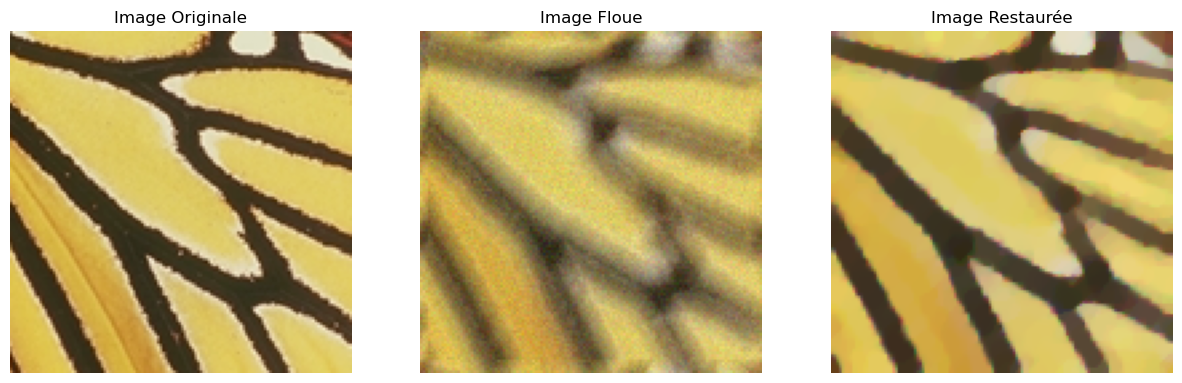

In [15]:
import deepinv as dinv
from pathlib import Path
import torch
from deepinv.utils.demo import load_degradation
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# Configuration des chemins
BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "datasets"  # Assurez-vous que ce dossier contient votre image
DEG_DIR = BASE_DIR / "degradations"

# Charger l'image unique
image_path = ORIGINAL_DATA_DIR / "butterfly.png"  # Remplacez par le chemin de votre image
image = Image.open(image_path).convert("RGB")

# Transformations
img_size = 128
val_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
image_tensor = val_transform(image).unsqueeze(0)  # Ajout de la dimension batch

# Configuration de l'appareil
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
image_tensor = image_tensor.to(device)

# Générer un opérateur de flou
# Génération d'un opérateur de flou
kernel_index = 1  # Choisissez un kernel parmi les disponibles
kernel_torch = load_degradation("Levin09.npy", DEG_DIR / "kernels", index=kernel_index)
kernel_torch = kernel_torch.unsqueeze(0).unsqueeze(0).to(device)  # Ajout de dimensions batch et canal


# Application du flou
# Application du flou
noise_level_img = 0.03
n_channels = 3
physics = dinv.physics.BlurFFT(
    img_size=(n_channels, img_size, img_size),
    filter=kernel_torch,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)

# Appliquer la dégradation à l'image
y = physics(image_tensor)

# Exploration du prior de variations totales
prior = dinv.optim.prior.TVPrior(n_it_max=2000)
cost_tv = prior(y).item()
print(f"Coût TV: g(y) = {cost_tv:.2f}")

# Appliquer l'opérateur proximal du prior TV
x_tv = prior.prox(y, gamma=0.1)
cost_tv_prox = prior(x_tv).item()

# Configuration de l'algorithme d'optimisation
data_fidelity = dinv.optim.data_fidelity.L2()
prior = dinv.optim.prior.TVPrior(n_it_max=20)

# Paramètres de l'algorithme
stepsize = 1.0
lamb = 1e-2  # Paramètre de régularisation TV
params_algo = {"stepsize": stepsize, "lambda": lamb}
max_iter = 300
early_stop = True

# Instanciation de l'algorithme
model = dinv.optim.optimizers.optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=True,
    params_algo=params_algo,
)

# Évaluation du modèle
x_model, metrics = model(
    y, physics, x_gt=image_tensor, compute_metrics=True
)

# Affichage des résultats
def show_images(original, blurred, restored):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title('Image Originale')
    axes[0].axis('off')

    axes[1].imshow(blurred.permute(1, 2, 0).cpu().numpy())
    axes[1].set_title('Image Floue')
    axes[1].axis('off')

    axes[2].imshow(restored.permute(1, 2, 0).cpu().numpy())
    axes[2].set_title('Image Restaurée')
    axes[2].axis('off')

    plt.show()

show_images(image_tensor.squeeze(), y.squeeze(), x_model.squeeze())

In [17]:
# compute PSNR
print(f"TV reconstruction PSNR: {dinv.metric.PSNR()(image_tensor,  x_model).item():.2f} dB")
print(f" PNP reconstruction PSNR: {dinv.metric.PSNR()(image_tensor, restored_image).item():.2f} dB")


TV reconstruction PSNR: 22.40 dB
 PNP reconstruction PSNR: 29.80 dB
